# **Handwritten Digits Images Generation Using GAN**

We will implement GAN using the MNIST dataset to generate handwritten digits similar to the images of the dataset.

**Import Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

**Load MNIST Dataset**

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Scale the inputs in range of (-1, +1) for better training
x_train, x_test = x_train / 255.0 * 2 - 1, x_test / 255.0 * 2 - 1

11490434/11490434 [==============================] - 0s 0us/step


**Show Images Examples From The MNIST Dataset**

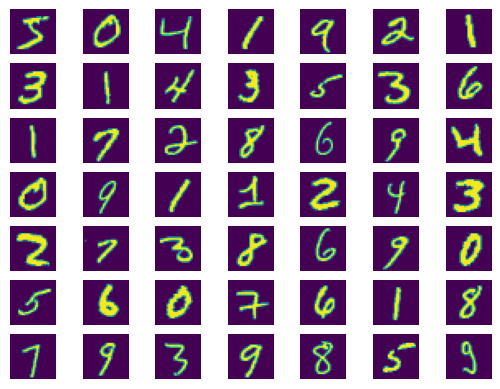

In [3]:
for i in range(49):
  plt.subplot(7, 7, i+1)
  plt.axis("off")
  #plot raw pixel data
  plt.imshow(x_train[i])
plt.show()

**Flatten Data**

We will flatten the dimension of the dataset from 3 to 2.

In [4]:
N, H, W = x_train.shape  #number, height, width
D = H * W   #dimension (28, 28)
x_train = x_train.reshape(-1, D)
x_test = x_test.reshape(-1, D)

**Define Generator Model**

The generator model consists of an input layer, three hidden layers followed by Batch normalization, and activation function as Leaky RELU and an output layer with activation function as tanh because a range of Image pixel is between -1 and +1.

In [5]:
latent_dim = 100 # number of inputs to the model

def build_generator(latent_dim):
  i = Input(shape=(latent_dim,))
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(D, activation='tanh')(x)  #because Image pixel is between -1 to 1.
  model = Model(i, x)  #i is input x is output layer
  return model

**Define Discriminator Model**

we will develop a simple Feed Forward Neural network for Discriminator where we will pass an image size. The activation function used is Leaky ReLU and you know the reason for it and sigmoid is used in the output layer for binary classification problems to classify Images as real or Fake.

In [6]:
def build_discriminator(img_size):
  i = Input(shape=(img_size,))
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
  x = Dense(1, activation='sigmoid')(x)
  model = Model(i, x)
  return model

**Compile Models**

In [7]:
# Build and compile the discriminator
discriminator = build_discriminator(D)
discriminator.compile ( loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

# Build and compile the combined model
generator = build_generator(latent_dim)

**Create Input To Represent Noise Sample**

We will create input to represent noise samples from latent space.

In [8]:
z = Input(shape=(latent_dim,))

**Pass Noise To Generator To Generate An Image**

In [9]:
img = generator(z)

**Pass Generator Image To Discriminator**

We will pass the generator Image to Discriminator and predict that it is Fake or real.

In [10]:
discriminator.trainable = False
fake_pred = discriminator(img)

In the initial phase, we need to make sure the discriminator is not trained and the image is Fake.

**Create Combined Generator Model**

We will create a combined Generator model with noise input and feedback of discriminator that helps the generator to improve its performance.

In [11]:
combined_model_gen = Model(z, fake_pred)  #first is noise and 2nd is fake prediction

**Compile The Combined Model**

In [12]:
combined_model_gen.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

**Define Parameters For GAN Training**

We will define epochs, batch size, and a sample period which means after how many steps the generator will create a sample. After this, we will define the Batch labels as one and zero. One represents that image is real and zero represents the image is fake.

In [13]:
batch_size = 32
epochs = 12000
sample_period = 200
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

**Store Generator And Discriminator Loss In Each Step Or Each Epoch**

We will create two empty lists to store the loss of generator and discriminator.

In [14]:
d_losses = []
g_losses = []

**Create File To Save Generated Image**

In [15]:
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

**Define Function That Create Simple Images**

We will create a function that generates a grid of random samples from a generator and saves them to a file. In simple words, it will create random images on some epochs. We define the row size as 5 and column as also 5 so in a single iteration or on a single page it will generate 25 images.

In [16]:
def sample_images(epoch):
  rows, cols = 5, 5
  noise = np.random.randn(rows * cols, latent_dim)
  imgs = generator.predict(noise)
  # Rescale images 0 - 1
  imgs = 0.5 * imgs + 0.5
  fig, axs = plt.subplots(rows, cols)  #fig to plot img and axis to store
  idx = 0
  for i in range(rows):  #5*5 loop means on page 25 imgs will be there
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(H, W), cmap='gray')
      axs[i,j].axis('off')
      idx += 1
  fig.savefig("gan_images/%d.png" % epoch)
  plt.close()

**Train Discriminator And Generator**

First, we will train the discriminator by passing the MNIST dataset real images and some fake images. Then, we will create a random noise grid and pass it to generator to generate an image. After, we will calculate the loss of both models and pass the label of a generated image as one to fool the discriminator making him beleive that it is capable of identifying fake images or no.

In [18]:
#FIRST we will train Discriminator(with real imgs and fake imgs)
# Main training loop
for epoch in range(epochs):
  ###########################
  ### Train discriminator ###
  ###########################
  # Select a random batch of images
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  real_imgs = x_train[idx]  #MNIST dataset
  # Generate fake images
  noise = np.random.randn(batch_size, latent_dim)  #generator to generate fake imgs
  fake_imgs = generator.predict(noise)
  # Train the discriminator
  # both loss and accuracy are returned
  d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)  #belong to positive class(real imgs)
  d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)  #fake imgs
  d_loss = 0.5 * (d_loss_real + d_loss_fake)
  d_acc  = 0.5 * (d_acc_real + d_acc_fake)
  #######################
  ### Train generator ###
  #######################
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model_gen.train_on_batch(noise, ones)
  #Now we are trying to fool the discriminator that generate imgs are real that's why we are providing label as 1
  # do it again!
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model_gen.train_on_batch(noise, ones)
  # Save the losses
  d_losses.append(d_loss)  #save the loss at each epoch
  g_losses.append(g_loss)
  if epoch % 100 == 0:
    print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")
  if epoch % sample_period == 0:
    sample_images(epoch)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 26ms/step
epoch: 7101/12000, d_loss: 0.67, d_acc: 0.64, g_loss: 0.76
1/1 [==============================] - 0s 29ms/step
epoch: 7201/12000, d_loss: 0.72, d_acc: 0.48, g_loss: 0.76
1/1 [==============================] - 0s 25ms/step
epoch: 7301/12000, d_loss: 0.69, d_acc: 0.52, g_loss: 0.76
1/1 [==============================] - 0s 40ms/step
epoch: 7401/12000, d_loss: 0.68, d_acc: 0.64, g_loss: 0.80
1/1 [==============================] - 0s 23ms/step
epoch: 7501/12000, d_loss: 0.72, d_acc: 0.39, g_loss: 0.77
1/1 [==============================] - 0s 26ms/step
epoch: 7601/12000, d_loss: 0.69, d_acc: 0.52, g_loss: 0.83
1/1 [==============================] - 0s 25ms/step
epoch: 7701/12000, d_loss: 0.69, d_acc: 0.56, g_loss: 0.76
1/1 [==============================] - 0s 32ms/step
epoch: 7801/12000, d_loss: 0.69, d_acc: 0.55, g_loss: 0.76
1/1 [==============================] - 0s 24ms/step
epoch: 79

We used 12000 epochs for training.

**Plot Loss Function**

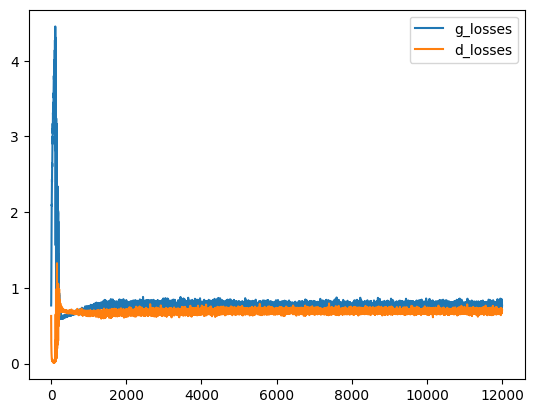

In [19]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

**Plot Generated Images At Zero Epoch**

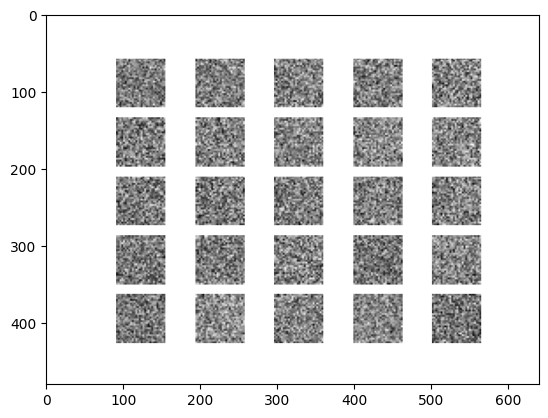

In [20]:
from skimage.io import imread

a = imread('gan_images/0.png')
plt.imshow(a)

No visible digits on the generated images and the discriminator identify them as fake.

**Plot Generated Images After 1000 Epoch Training**

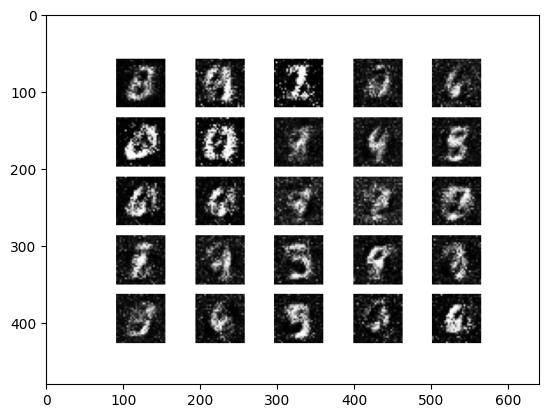

In [21]:
a = imread('gan_images/1000.png')
plt.imshow(a)

A digit shape is visible but the images were not clear enough to identify those digits.

**Plot Generated Images After 10000 Epoch Training**

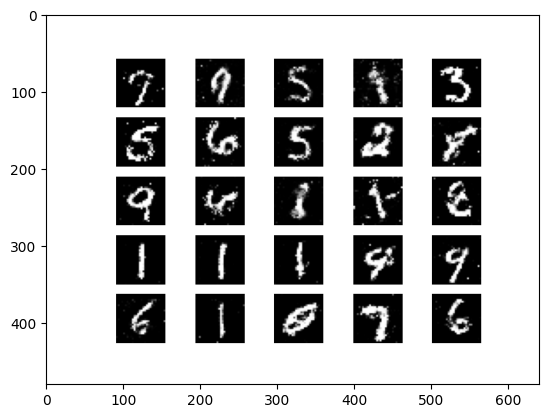

In [22]:
a = imread('gan_images/10000.png')
plt.imshow(a)

The images generated are similar to the MNIST dataset and have high chances to fool the discriminator.